In [1]:
import os
import numpy as np
import pandas as pd
import pydicom
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Load the CSV file with image paths and labels
df = pd.read_csv('RSNA_breast_cancer_data.csv')

# Function to load DICOM images and resize them to 224x224 (for EfficientNet)
def load_dicom_image(image_path, target_size=(224, 224)):
    dicom = pydicom.dcmread(image_path)
    image = dicom.pixel_array  # Load pixel array
    image_resized = cv2.resize(image, target_size)  # Resize the image
    image_normalized = image_resized / np.max(image_resized)  # Normalize pixel values
    return image_normalized

In [3]:
# Load image paths and labels
image_paths = df['image_path'].values
labels = df['cancer'].values

# Load and preprocess all images
images = np.array([load_dicom_image(path) for path in image_paths])
labels = np.array(labels)

In [6]:
images.shape

(2374, 224, 224)

In [4]:
# Split data into training (70%), validation (10%), and test sets (20%)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=42)  # 10% for val, 20% for test

# Normalize images to be between 0 and 1
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [7]:
# Add a channels dimension (1 for grayscale)
X_train = np.expand_dims(X_train, axis=-1)  # Shape becomes (1661, 224, 224, 1)
X_val = np.expand_dims(X_val, axis=-1)      # Apply to validation set as well

In [10]:
print(X_train.shape) 

(1661, 224, 224, 1)


In [8]:
# Create ImageDataGenerator for real-time data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create the validation data generator (just rescaling)
val_datagen = ImageDataGenerator()

# Flow the data using ImageDataGenerator
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [9]:
# Build an EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Create a new model on top of EfficientNetB0
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [11]:
# Train the model using the generators
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=30,
    validation_data=val_generator,
    validation_steps=len(X_val) // 32
)

Epoch 1/30


c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 670ms/step - accuracy: 0.4860 - loss: 0.7071 - val_accuracy: 0.4777 - val_loss: 0.6944
Epoch 2/30
 1/51 ━━━━━━━━━━━━━━━━━━━━ 27s 557ms/step - accuracy: 0.5000 - loss: 0.7110

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.5000 - loss: 0.7110 - val_accuracy: 0.4866 - val_loss: 0.6940
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 623ms/step - accuracy: 0.5247 - loss: 0.6928 - val_accuracy: 0.5179 - val_loss: 0.6927
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.5938 - loss: 0.6845 - val_accuracy: 0.5223 - val_loss: 0.6922
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 33s 641ms/step - accuracy: 0.4958 - loss: 0.6979 - val_accuracy: 0.5179 - val_loss: 0.6930
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.5000 - loss: 0.6866 - val_accuracy: 0.5045 - val_loss: 0.6956
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 617ms/step - accuracy: 0.4900 - loss: 0.7022 - val_accuracy: 0.5045 - val_loss: 0.6932
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.5938 - loss: 0.6863 - val_accuracy: 0.5134 - val_loss: 0.6928
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 612ms/step - accuracy: 0.4949 - loss: 0.7002 - val_accuracy: 0.5179 - val_

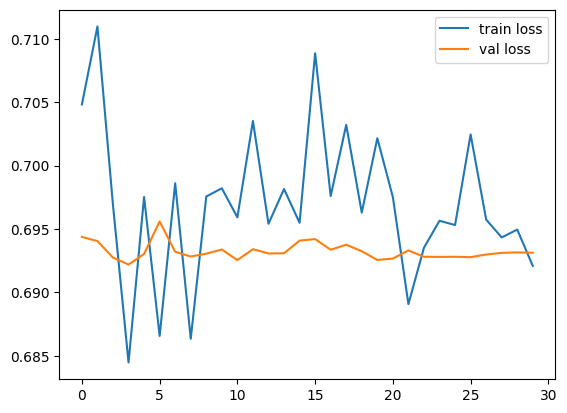

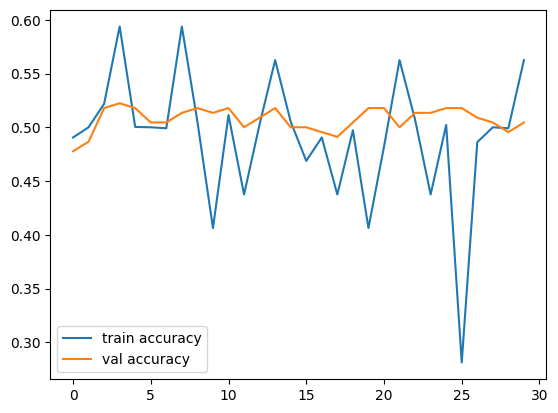

In [30]:
# Plot learning curves
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()


In [14]:
# For grayscale images, add the channels dimension
X_test = np.expand_dims(X_test, axis=-1)
print(X_test.shape)

(478, 224, 224, 1)


In [15]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 536ms/step - accuracy: 0.5058 - loss: 0.6931

Test accuracy: 0.5271966457366943


15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 520ms/step


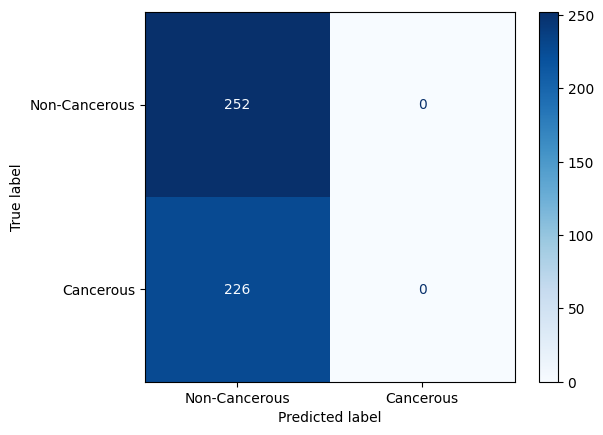

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions on the test set
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary class labels
y_pred = (y_pred_probs > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [17]:
print(cm)

[[252   0]
 [226   0]]


In [18]:
df['cancer'].value_counts()

cancer
0    1218
1    1156
Name: count, dtype: int64

In [25]:
# Inspect the first 10 predicted probabilities
print(y_pred_probs[:10])
print(y_pred[:10])

[[0.49859408]
 [0.49859372]
 [0.49859345]
 [0.49859372]
 [0.49859354]
 [0.49859354]
 [0.49859396]
 [0.49859378]
 [0.4985935 ]
 [0.49859357]]
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
